In [1]:

%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp

figsize(20,6)

import tensorflow as tf
tf.enable_eager_execution()

prefix="osc_rect"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

(123,) 8000


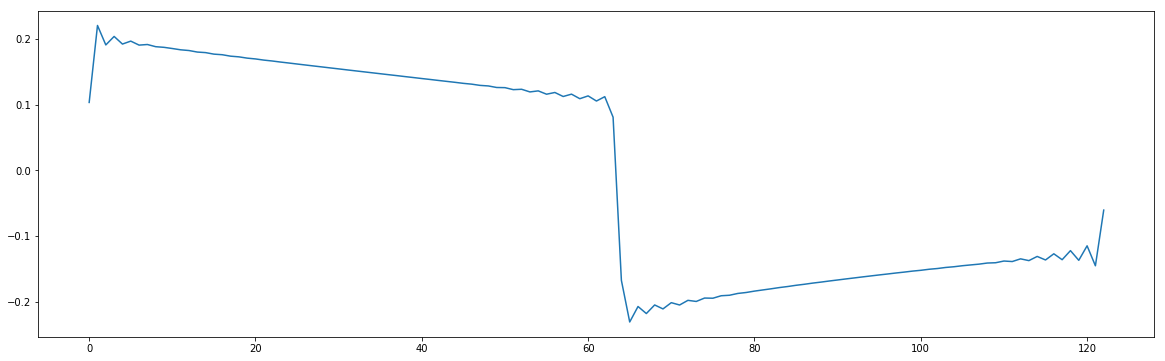

In [3]:
y, sr = librosa.load("audios/397428__cabled-mess__doepfer-a-110-1-vco-rectangle-c2-8k.wav", sr=8000)
y = y[0:123]
plot(y)
windowSize = len(y)
# nWindows = 1
print(y.shape,  sr)

In [4]:

Audio(data=y[:],rate=sr)

In [5]:
#divide out windows
patterns = np.zeros(1, dtype=np.object)
patterns[0] = np.array(y,dtype=float64)
# for i in range(nWindows):
#     patterns[i] = y[i*windowSize : (i+1) * windowSize]
# patterns = np.zeros((1,windowSize))
# patterns[0] = y

In [6]:
patterns[0].dtype

dtype('float64')

In [7]:
windowSize

123

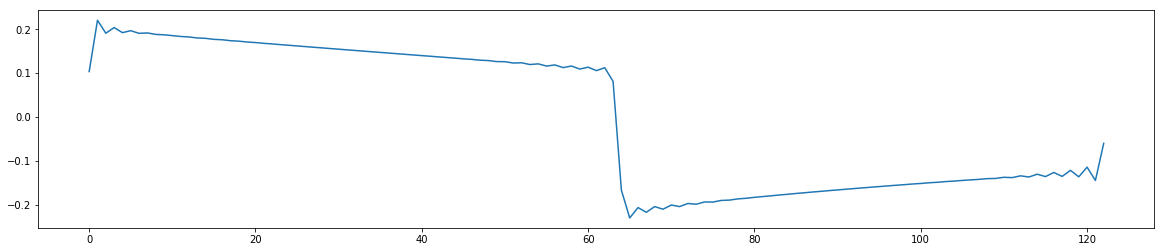

In [8]:
figsize(20,4)
for i in range(int(patterns.shape[0])):
    plot(patterns[i])

In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tfdevice='/cpu:0'

In [10]:
#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    with tf.device(tfdevice):
        Netconnectivity = 1
        if p['N'] > 20:
            Netconnectivity = 10.0/p['N'];
        WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
        WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
        WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

        #Scale raw weights     
        Wstar = p['NetSR'] * WstarRaw;
        Win = p['NetinpScaling'] * WinRaw;
        Wbias = p['BiasScaling'] * WbiasRaw;  
        I = np.eye(p['N'])
        xCollector = np.zeros((p['N'], p['learnLength']))
        pCollector = np.zeros((1, p['learnLength']))
        x = np.zeros((p['N'],1))

        allTrainxArgs = np.zeros((p['N'] + 1, 0));
        allTrainOldxArgs = np.zeros((p['N'], 0));
        allTrainWtargets = np.zeros((p['N'], 0));
        allTrainOuts = np.zeros((1, 0));
        patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
        print('Loading patterns: ', end='')
        for i_pattern in range(p['patts'].shape[0]):
            print(i_pattern, " ", end='')
            patt = p['patts'][i_pattern]
            xCollector = np.zeros((p['N'] + 1, p['learnLength']));
            xOldCollector = np.zeros((p['N'], p['learnLength']));
            WTargetCollector = np.zeros((p['N'], p['learnLength']));
            pCollector = np.zeros((1, p['learnLength']));
            x = np.zeros((p['N'], 1));

            for n in range(p['washoutLength'] + p['learnLength']):
                u = patt.take(n, mode='wrap')
                xOld = x
    #             Wtarget = (Wstar.dot(x)) + (Win.dot(u))
                wstarx=tf.matmul(Wstar,x)
                winu = tf.multiply(Win,u)
                Wtarget = tf.add(wstarx, winu)
    #             x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
                xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
                biasedTarget = tf.add(Wtarget, Wbias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
                x = tf.add(xOldLR, biasedTargetLR)
                if n >= p['washoutLength']:
                    xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                    xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                    WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                    pCollector[0, n - p['washoutLength']] = u
                uOld = u

            R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
            patternRs[0,i_pattern] = R
            allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
            allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
            allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
            allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


        Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                          (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

        outsRecovered = Wout.dot(allTrainxArgs);
        NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
        absSize_readout = mean(mean(abs(Wout), axis=0))
        print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
        print("absSize readout: ", absSize_readout)

        W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                          (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
        NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
        absSize_W = mean(mean(abs(W), axis=0))
        print("NRMSE W: ", NRMSE_W, " :: ", end='')
        print("absSize W: ", absSize_W)

    return locals()


    
params = {'N':800, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.001,
         'washoutLength':windowSize*4, 'learnLength':windowSize * 8, 'TychonovAlphaReadout':0.001,
          'LR': 0.5,
          'patts':patterns[np.arange(1)]
         }



sampleSize = 15
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_W'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], "avg: ", np.mean(nrmses) )


0
Loading patterns: 0  
NRMSE readout:  0.0012306501226874381  :: absSize readout:  0.011530873505453135
NRMSE W:  0.00655062631592293  :: absSize W:  0.08230525364236499
1
Loading patterns: 0  
NRMSE readout:  0.0008652902649638653  :: absSize readout:  0.010468005569878513
NRMSE W:  0.008786656949285989  :: absSize W:  0.09251574897275151
2
Loading patterns: 0  
NRMSE readout:  0.0009320622449792026  :: absSize readout:  0.009460447846415327
NRMSE W:  0.007998077534209846  :: absSize W:  0.0891564529596012
3
Loading patterns: 0  
NRMSE readout:  0.0007986327040109821  :: absSize readout:  0.009781387519310755
NRMSE W:  0.007214901027877673  :: absSize W:  0.0863973827190179
4
Loading patterns: 0  
NRMSE readout:  0.0006966450777842002  :: absSize readout:  0.009264592707395075
NRMSE W:  0.006546371620232147  :: absSize W:  0.08117379727728141
5
Loading patterns: 0  
NRMSE readout:  0.0009162963733252536  :: absSize readout:  0.010196487426958141
NRMSE W:  0.004474616644321339  :: abs

In [11]:
%%time
def computeConceptor(p, net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    with tf.device(tfdevice):    
        Cs = np.zeros((4, 1), dtype=np.object)
        R = net['patternRs'][0,i_pattern]
#         [s,U,V] = tf.svd(R)
        [U,s,V] = svd(R)

#         S = diag(s)
        S = tf.diag(s)
    #     U = U.numpy()

        sinv = tf.matrix_inverse(tf.add(S, tf.multiply(double(pow(alpha, -2)), tf.eye(p['N'], dtype=float64))))
        Snew = tf.matmul(S,sinv)
    #     Snew = tf.matmul(Snew, tf.eye(p['N'], dtype=float64))
        Snew = Snew.numpy()
    #     Snew = (S * linalg.inv(S + pow(alpha, -2) * np.eye(p['N'])))

        C = tf.matmul(U,Snew)
        C = tf.matmul(C,U, adjoint_b=True).numpy()
#     C =  U.dot(Snew).dot(U.conj().T);

    Cs[0,0] = C
    Cs[1,0] = U
    Cs[2,0] = diag(Snew)
    Cs[3,0] = diag(S)

    return locals()

def testConceptor(p, cNet, recallTestLength):
    with tf.device(tfdevice):    
        trials = 1
        attens = np.zeros(trials)
        C = cNet['Cs'][0,0]
        for i_trial in range(trials):
            x_CTestPL = np.zeros((p['N'], recallTestLength))
            z_CTestPL = np.zeros((p['N'], recallTestLength))
    #         p_CTestPL = np.zeros((1, recallTestLength))
            x = 0.5 * np.random.randn(p['N'],1)
            z = x
    #         matW = tf.constant(cNet['net']['W'])
            for n in range(recallTestLength + p['washoutLength']):
                xOld = x
                Wtarget = (cNet['net']['W'].dot(x))
    #             Wtarget = tf.matmul(matW, x).numpy()

                z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))

    #             xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
    #             biasedTarget = tf.add(Wtarget, cNet['net']['Wbias'])
    #             biasedTarget = tf.tanh(biasedTarget)
    #             biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
    #             z = tf.add(xOldLR, biasedTargetLR)

                x = C.dot(z)
    #             x = tf.matmul(C,z).numpy()
                xPrev = x
                if (n > p['washoutLength']):
                    x_CTestPL[:,n-p['washoutLength']] = x.T
    #                 z_CTestPL[:,n-p['washoutLength']] = z.numpy().T
                    z_CTestPL[:,n-p['washoutLength']] = z.T
    #                 p_CTestPL[:,n-p['washoutLength']] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))

    #         attenuation = np.mean(pow(np.sum(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.sum(z_CTestPL[:,:], axis=1),2))
            attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
            attens[i_trial] = attenuation
        
    return np.mean(attens)

# nTrials = 200
# trialResults= np.zeros(nTrials)
# for i in range(nTrials):
#     cnet = computeConceptor(params, loadedNets[bestNetwork], 0, (i + 1))
#     atten = testConceptor(params, cnet, windowSize*10, 0)
#     trialResults[i] = atten
#     print(atten)
    
# plot(trialResults)

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 14.1 µs


In [12]:
%%time
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cnet = computeConceptor(params, loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(params, cnet, windowSize*10)
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

#store conceptors with calculated apertures
patternCs = np.zeros(len(apertures), dtype=np.object)
for i_patt in range(patternCs.size):
    print(i_patt, " ", end='')
    patternCs[i_patt] = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])
print("Done")

Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  1.08763e-06        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034  9.37151e-07        golden
Pattern:  0
Computing conceptor, alpha:  763.9320225002102
    3        763.932  1.07372e-06        golden
Pattern:  0
Computing conceptor, alpha:  577.3699057330165
    4         577.37  8.59634e-07        parabolic
Pattern:  0
Computing conceptor, alpha:  502.7322595746424
    5        502.732  9.30579e-07        golden
Pattern:  0
Computing conceptor, alpha:  559.2330252919428
    6        559.233  8.32827e-07        parabolic
Pattern:  0
Computing conceptor, alpha:  551.1080760268333
    7        551.108  8.29714e-07        parabolic
Pattern:  0
Computing conceptor, alpha:  550.5760714316791
    8        550.576  1.01948e-06        parabolic
Pattern:  0
Computing conceptor, alpha:  551.4414175344203
    9        551.44

0.1124108689979582


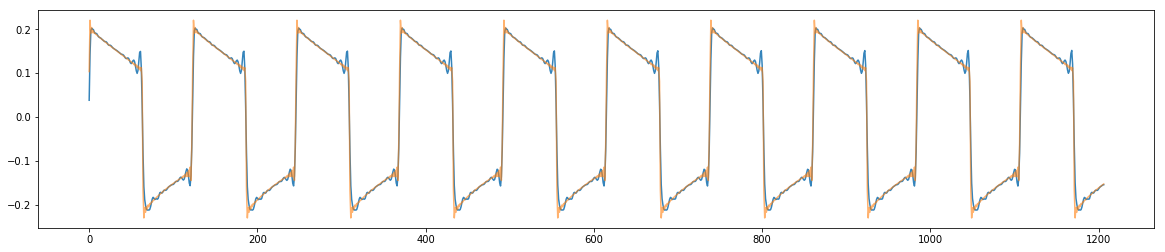

In [13]:
def plotConceptorPattern(p, cNet, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    z_CTestPL = np.zeros((p['N'], recallTestLength, p['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].shape[0]))
    C = cNet['Cs'][0,0]
    x = 0.5 * np.random.randn(p['N'],1)
    z = x
    for n in range(recallTestLength + p['washoutLength']):
        xOld = x
        Wtarget = (cNet['net']['W'].dot(x))
        z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > p['washoutLength']):
            x_CTestPL[:,n-p['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-p['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-p['washoutLength'],i_pattern] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
#         ax = subplot(subr, p['patts'].shape[0], suboff + i_pattern + 1)
#         ax.set_title("S:" + str(int(suboff/p['patts'].shape[0])) + ", p: " + str(i_pattern) + ", a: " + str(cNet['alphas'][i_pattern]))
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:p['patts'][i_pattern].size*2],p['patts'][i_pattern])
#     print(templateScan)
    matchPoint = np.argmax(templateScan)
#     print(matchPoint)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern,alpha=0.9)
    plot(targetPattern, alpha=0.6)
#     plot(p_CTestPL[:,:,i_pattern].T)
#     plot([p['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])

figsize(20,4)
for i_patt in range(len(apertures)):
    subplot(len(apertures), 1, i_patt+1)
#    cnet = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])
    plotConceptorPattern(params, patternCs[i_patt], windowSize * 10, i_patt)

plt.savefig(filepre("tests.pdf"))

In [176]:
# import dill as pickle
# ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
# with open(r"models/osc_c2_rect" + ts + ".pickled", "wb") as output_file:    
#     pickle.dump(patternCs, output_file, protocol=0)

In [14]:
def conceptorAnd(C1, C2):
    return np.linalg.inv(np.linalg.inv(C1) + np.linalg.inv(C2) - np.eye(C1.shape[0]))

def render(p,srCtl, lrCtl, oversample=1, rl=8000):
    audio = np.zeros(rl)
    with tf.device(tfdevice):
        x = tf.contrib.eager.Variable(0.5 * np.random.randn(p['N'],1))
    #     x = 0.5 * np.random.randn(p['N'],1)

        cNet = patternCs[0]
        C1 = tf.constant(cNet['Cs'][0,0])
        C = C1
        srCtl = tf.constant(srCtl)
        orgLR = p['LR']
        LR = orgLR
        matW = tf.constant(cNet['net']['W'])
        matBias = tf.constant( cNet['net']['Wbias'])
        matWout = tf.constant(cNet['net']['Wout'])  
        tfone = tf.constant(double(1.0), dtype=float64)
        #run to washout
        for n in range(500):
            xOld = x
            Wtarget = tf.matmul(matW, x)
            xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
            biasedTarget = tf.add(Wtarget, matBias)
            biasedTarget = tf.tanh(biasedTarget)
            biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
            z = tf.add(xOldLR, biasedTargetLR)
            x = tf.matmul(C,z)


        for n in range(rl):
            LR = double(orgLR * lrCtl[n])
            if n % 500 == 0:
                print(n, " / ", rl)
                print(LR)
            newSample=0
            for i_oversample in range(oversample):
                xOld = x
                Wtarget = tf.matmul(tf.multiply(srCtl[n],matW), x)

                xOldLR = tf.multiply(double(1.0-LR), xOld)
                biasedTarget = tf.add(Wtarget, matBias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(LR, biasedTarget)
                z = tf.add(xOldLR, biasedTargetLR)
                x = tf.matmul(C,z)
                xBias = tf.concat([tf.transpose(x)[0],[1]],0)
                xBias = tf.expand_dims(xBias,1)
                netOutput = tf.matmul(matWout, xBias)
                newSample = newSample + netOutput.numpy()

            audio[n] = newSample/oversample
    return audio



CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


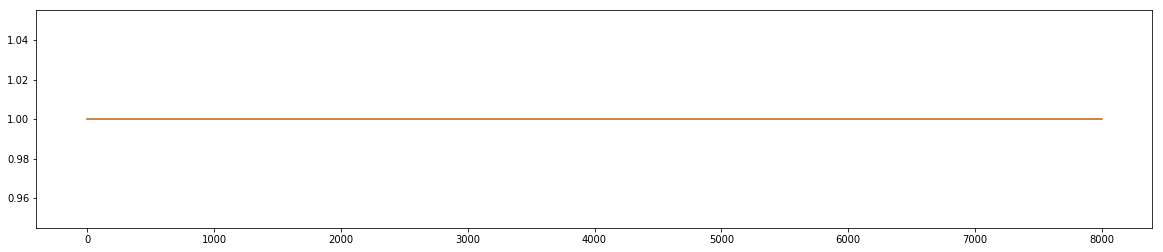

In [15]:
%time
rl = 8000
def saw(renderLen, freq, phase):
    ar = np.zeros(renderLen)
    waveLen = 1.0/freq * sr
    inc = 1 / waveLen
    
    for i in range(renderLen):
        ar[i] = phase
        phase = phase + inc
        if phase > 1.0:
            phase = phase - 1.0
    return ar

def pulse(renderLen, freq, phase, pulseWidth):
    ar = np.zeros(renderLen)
    waveLen = 1.0/freq * sr
    inc = 1 / waveLen
    
    for i in range(renderLen):
        ar[i] = phase < pulseWidth
        phase = phase + inc
        if phase > 1.0:
            phase = phase - 1.0
    return ar
    

figsize(20,4)
fig =figure(1)
srCtl = saw(rl, 1/16.,0) * 0.0 + 1
lrCtl = saw(rl, 1/2.,0.5) * 1.4 + 0.2 
lrCtl = lrCtl * 0 + 1

# plt.title("Conceptor Morph")
plot(srCtl)
plot(lrCtl)
    
    

In [16]:
%%time

# %lprun render(params, mixCtl, srCtl, lrCtl, rl=rl, oversample=1, )
audio = render(params, srCtl, lrCtl, rl=rl, oversample=1, )
print("done")

0  /  8000
0.5
500  /  8000
0.5
1000  /  8000
0.5
1500  /  8000
0.5
2000  /  8000
0.5
2500  /  8000
0.5
3000  /  8000
0.5
3500  /  8000
0.5
4000  /  8000
0.5
4500  /  8000
0.5
5000  /  8000
0.5
5500  /  8000
0.5
6000  /  8000
0.5
6500  /  8000
0.5
7000  /  8000
0.5
7500  /  8000
0.5
done
CPU times: user 25.2 s, sys: 1.33 s, total: 26.5 s
Wall time: 14.3 s


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


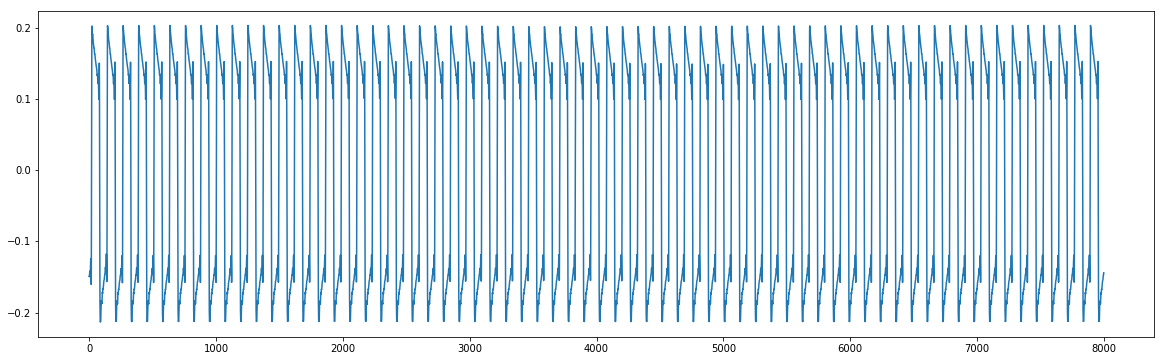

In [17]:
figsize(20,6)
plot(audio)
librosa.output.write_wav(filepre("rectRecon.wav"), librosa.resample(audio, sr, 44100), 44100)
Audio(data=audio,rate=sr)


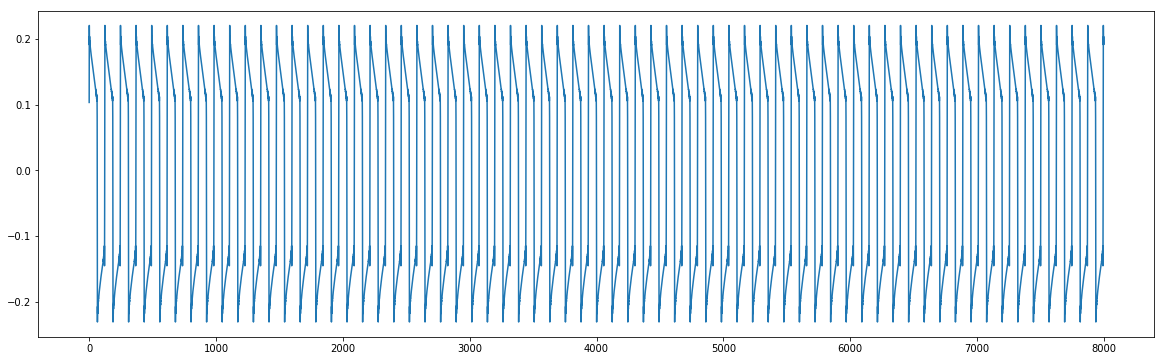

In [18]:
#reference pattern
y = np.array([patterns[0].take(x, mode='wrap') for x in arange(rl)])
plot(y)
Audio(data=y,rate=sr)

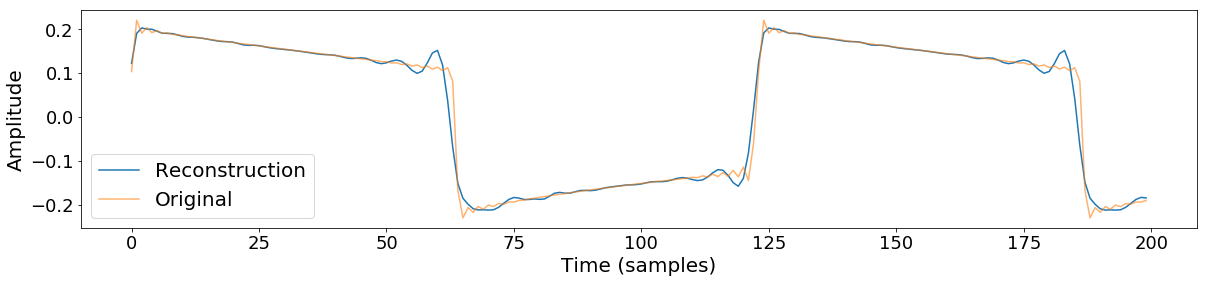

In [42]:
figsize(20,4)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(audio[143:343],alpha=1.0, label='Reconstruction')
plot(y[:200],alpha=0.6, label='Original')
plt.legend(fontsize=20)
plt.savefig(filepre("wavecompare.pdf"), bbox_inches='tight')

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


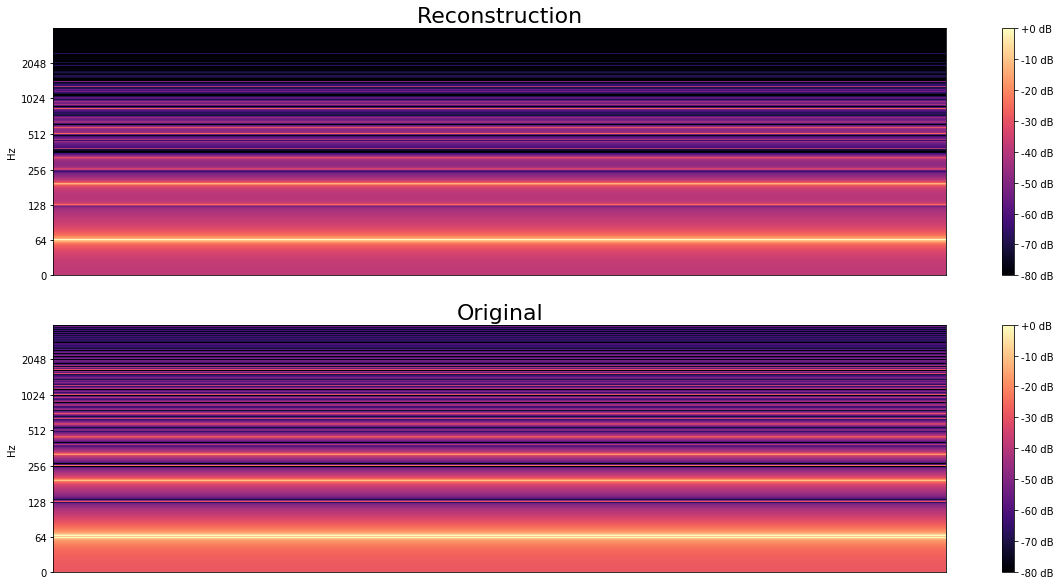

In [44]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=8192, hop_length=8192), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=8000)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y, n_fft=8192, hop_length=8192), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=8000)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig(filepre("exptSpectra.pdf"), bbox_inches='tight')

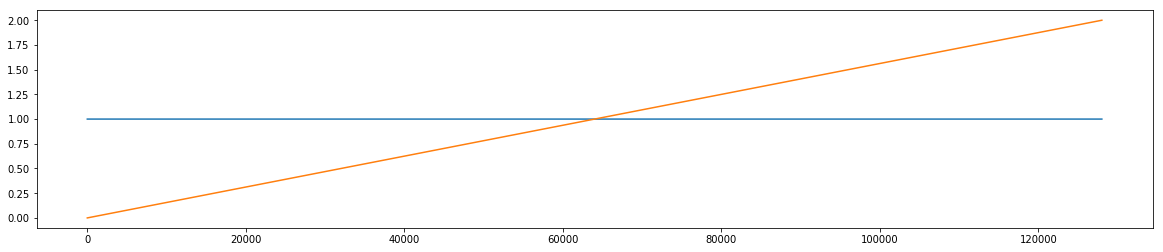

In [45]:
#pitch using the leak rate? YES!
rl=8000*16
figsize(20,4)
fig =figure(1)
# mixCtl = (saw(rl, 3, 0) * pulse(rl, 1.5, 0.5, 0.5)) + pulse(rl,0.75, 0.5, 0.5)
srCtl = np.ones(rl)
lrCtl = saw(rl, 1./16,0) * 2
# plt.title("Conceptor Morph")
plot(srCtl)
plot(lrCtl)
    

In [46]:
audio2 = render(params, srCtl, lrCtl, rl=rl)
print("done")

0  /  128000
0.0
500  /  128000
0.003906250000000003
1000  /  128000
0.007812500000000005
1500  /  128000
0.011718749999999575
2000  /  128000
0.015624999999999145
2500  /  128000
0.019531249999998716
3000  /  128000
0.023437499999998286
3500  /  128000
0.027343749999997856
4000  /  128000
0.031249999999997426
4500  /  128000
0.03515624999999873
5000  /  128000
0.039062500000000035
5500  /  128000
0.04296875000000134
6000  /  128000
0.046875000000002644
6500  /  128000
0.05078125000000395
7000  /  128000
0.05468750000000525
7500  /  128000
0.05859375000000656
8000  /  128000
0.06250000000000785
8500  /  128000
0.06640625000000569
9000  /  128000
0.07031250000000352
9500  /  128000
0.07421875000000136
10000  /  128000
0.0781249999999992
10500  /  128000
0.08203124999999703
11000  /  128000
0.08593749999999487
11500  /  128000
0.0898437499999927
12000  /  128000
0.09374999999999054
12500  /  128000
0.09765624999998837
13000  /  128000
0.1015624999999862
13500  /  128000
0.105468749999984

113000  /  128000
0.8828125000013711
113500  /  128000
0.8867187500013898
114000  /  128000
0.8906250000014084
114500  /  128000
0.8945312500014271
115000  /  128000
0.8984375000014457
115500  /  128000
0.9023437500014644
116000  /  128000
0.906250000001483
116500  /  128000
0.9101562500015017
117000  /  128000
0.9140625000015203
117500  /  128000
0.917968750001539
118000  /  128000
0.9218750000015576
118500  /  128000
0.9257812500015763
119000  /  128000
0.929687500001595
119500  /  128000
0.9335937500016136
120000  /  128000
0.9375000000016322
120500  /  128000
0.9414062500016509
121000  /  128000
0.9453125000016696
121500  /  128000
0.9492187500016882
122000  /  128000
0.9531250000017069
122500  /  128000
0.9570312500017255
123000  /  128000
0.9609375000017442
123500  /  128000
0.9648437500017628
124000  /  128000
0.9687500000017815
124500  /  128000
0.9726562500018001
125000  /  128000
0.9765625000018188
125500  /  128000
0.9804687500018374
126000  /  128000
0.9843750000018561
1265

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


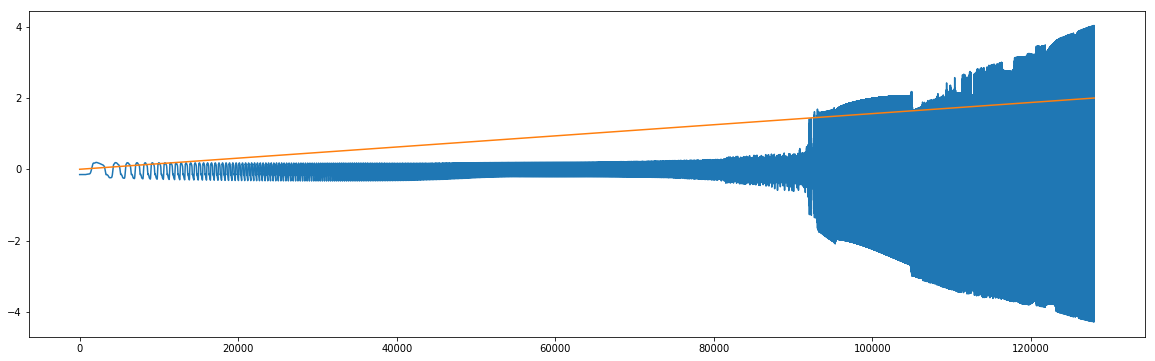

In [47]:
figsize(20,6)
plot(audio2)
plot(lrCtl)
librosa.output.write_wav(filepre("rect_pitch_rise.wav"), librosa.resample(audio2/np.max(audio2), sr, 44100), 44100)
plt.savefig(filepre("pitchRiseTS.pdf"))
Audio(data=audio2,rate=sr)


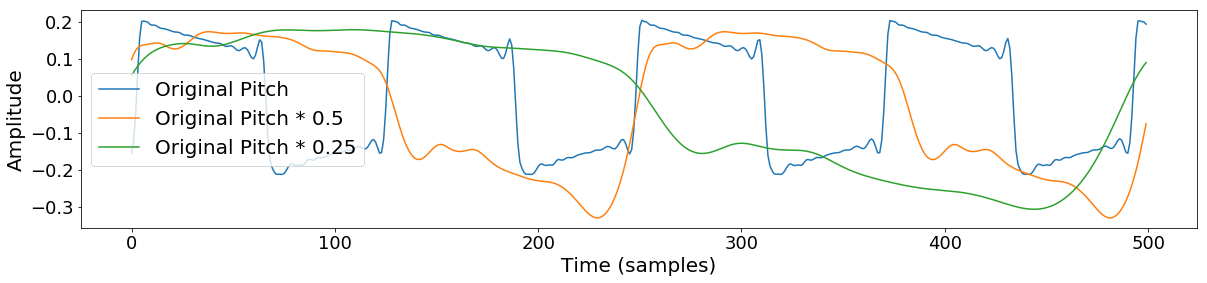

In [114]:
figsize(20,4)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
len = 500
st1 = 64000 + 12
plot(audio2[st1:st1+len], label="Original Pitch")
st2=int(st1/2) + 60 - 120
plot(audio2[st2:st2+len], label="Original Pitch * 0.5")
st3=int(st2/2) + 70
plot(audio2[st3:st3+len], label="Original Pitch * 0.25")
plt.legend(fontsize=20)
plt.savefig(filepre("osc3octaves.pdf"), bbox_inches='tight')

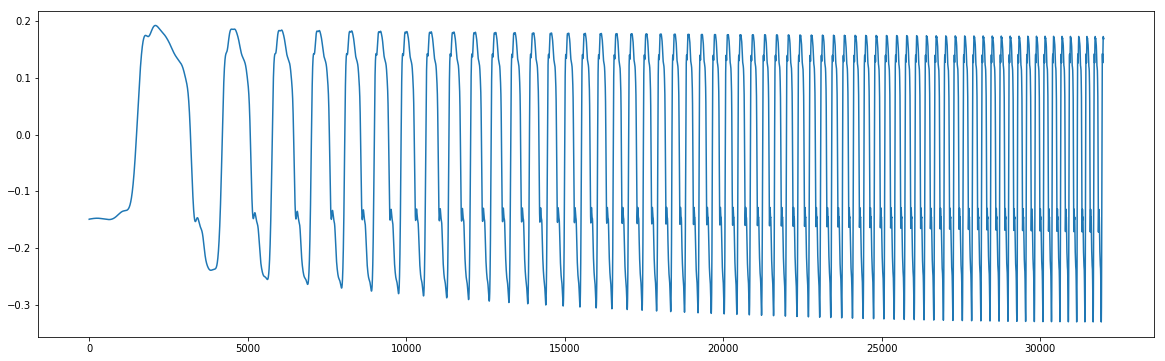

In [49]:
plot(audio2[:32000])

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


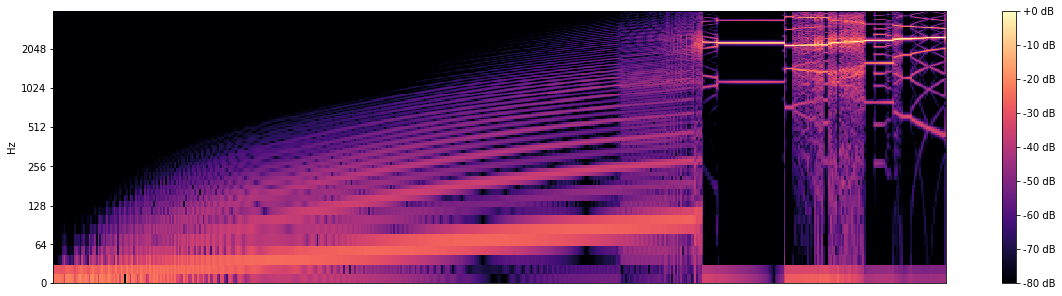

In [50]:
figsize(20,5)
import librosa.display
CQT = librosa.amplitude_to_db(librosa.stft(audio2, n_fft=512, hop_length=256), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=8000)
plt.colorbar(format='%+2.0f dB')
#ax.set_title('Reconstruction', fontsize=22)
plt.savefig(filepre("pitchRise.pdf"), bbox_inches='tight')

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         7.93650794
 7.93650794 7.93650794 7.93650794 7.93650794 7.9

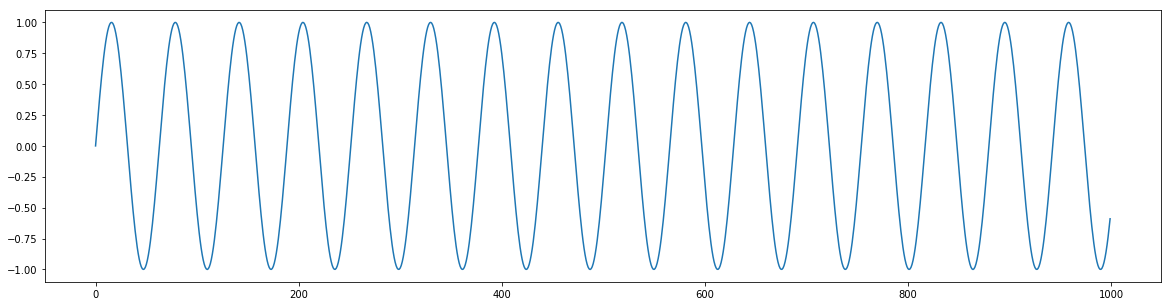

In [51]:
q = sin(arange(1000) / 10)
plot(q)
def zxDetect(w, sr): #detect pitch from zero crossings
    pitch=0
    result = np.zeros_like(w)
    result[0]=0
    
    lastCrossingIdx=-1
    lastValue=w[0]
    for i,v in enumerate(w[1:]):
        if lastValue > 0 and v <=0:
            if lastCrossingIdx != -1:
                wavelen = i + 1 - lastCrossingIdx
                pitch = float(sr) / wavelen
            lastCrossingIdx = i+1
        lastValue = v
        result[i+1] = pitch
    return result
        
pitches=zxDetect(q, 500)
print(pitches)
        

In [68]:
pitches=zxDetect(audio2[:64000], 8000)
pitches

array([ 0.        ,  0.        ,  0.        , ..., 65.04065041,
       65.04065041, 65.04065041])

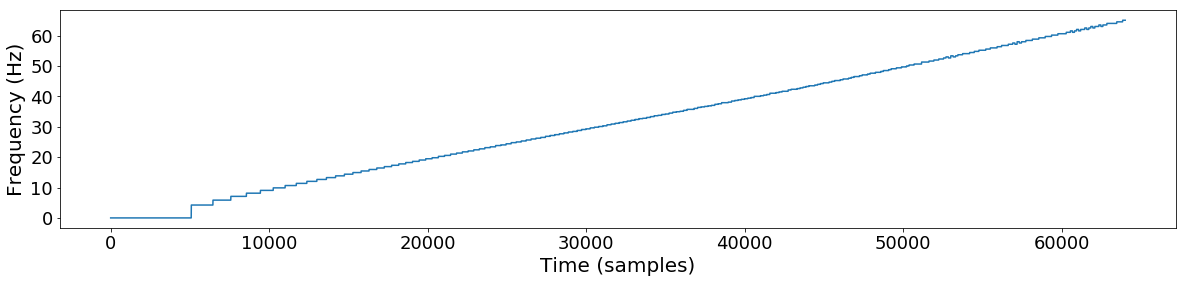

In [79]:
pitches=zxDetect(audio2[:64000], 8000)
xseries = np.linspace(0,64000,pitches.shape[0])
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel(r'Frequency (Hz)', fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plot(xseries,pitches)

plt.savefig(filepre("pitchRiseAnalysis.pdf"), bbox_inches="tight")

0  /  96000
0.3745767692191704
500  /  96000
0.3745767692191704
1000  /  96000
0.0
1500  /  96000
0.3745767692191704
2000  /  96000
0.3745767692191704
2500  /  96000
0.0
3000  /  96000
0.3745767692191704
3500  /  96000
0.3745767692191704
4000  /  96000
0.0
4500  /  96000
0.3337099635425086
5000  /  96000
0.3337099635425086
5500  /  96000
0.0
6000  /  96000
0.0
6500  /  96000
0.0
7000  /  96000
0.0
7500  /  96000
0.0
8000  /  96000
0.0
8500  /  96000
0.0
9000  /  96000
0.0
9500  /  96000
0.0
10000  /  96000
0.0
10500  /  96000
0.0
11000  /  96000
0.0
11500  /  96000
0.0
12000  /  96000
0.3745767692191704
12500  /  96000
0.3745767692191704
13000  /  96000
0.0
13500  /  96000
0.3745767692191704
14000  /  96000
0.3745767692191704
14500  /  96000
0.0
15000  /  96000
0.3745767692191704
15500  /  96000
0.3745767692191704
16000  /  96000
0.0
16500  /  96000
0.3337099635425086
17000  /  96000
0.3337099635425086
17500  /  96000
0.0
18000  /  96000
0.0
18500  /  96000
0.0
19000  /  96000
0.0
1950

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


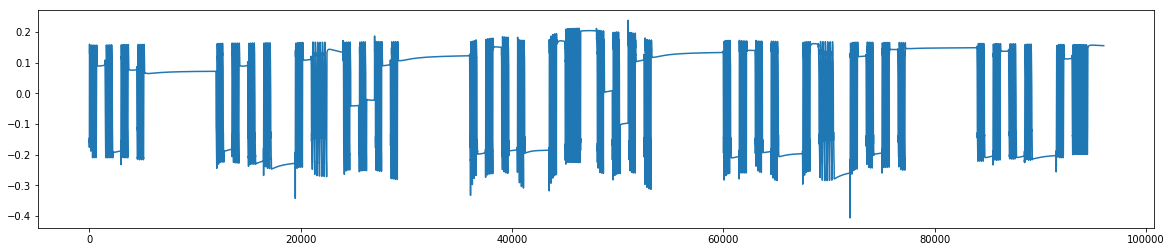

In [76]:
#the bass line from Interface, Prince Jammy / Computerised Dub
#note mappings
figsize(20,4)
rl=96000
sequence=np.array([7,-1,7,-1,7,-1,5,-1, -1,-1,-1,-1,-1,-1,-1,-1,7,-1,7,-1,7,-1,5,-1,-1,-1,7,-1,2,2,-1,-1])
sequence=np.append(sequence, np.array([7,-1,7,-1,7,-1,5,-1, -1,-1,-1,-1,-1,-1,-1,-1,7,-1,7,-1,7,-1,5,-1,-1,-1,7,-1,10,10,-1,-1]))
#repeat
sequence = np.append(sequence, sequence)

stepSize = int(rl/sequence.shape[0])
half = int(rl/2)
srCtl = (saw(half, 8000/half,0) * 0.05) + 0.96
srCtl = np.append(srCtl, ((1.0 - saw(half, 8000/half,0)) * 0.05) + 0.96)
lrCtl = np.zeros(0)
for note in sequence:
    lrCtl = np.append(lrCtl, np.ones(stepSize) * 0.5 * (pow(2,note/12) if note >= 0 else 0))

audio3 = render(params, srCtl, lrCtl, rl=lrCtl.shape[0])
pitches=zxDetect(audio3, 8000)
# plot(pitches)
plot(audio3)
librosa.output.write_wav(filepre("jammy.wav"), librosa.resample(audio3, sr, 44100), 44100)
plt.savefig(filepre("seqts.pdf"))
Audio(data=audio3,rate=sr)


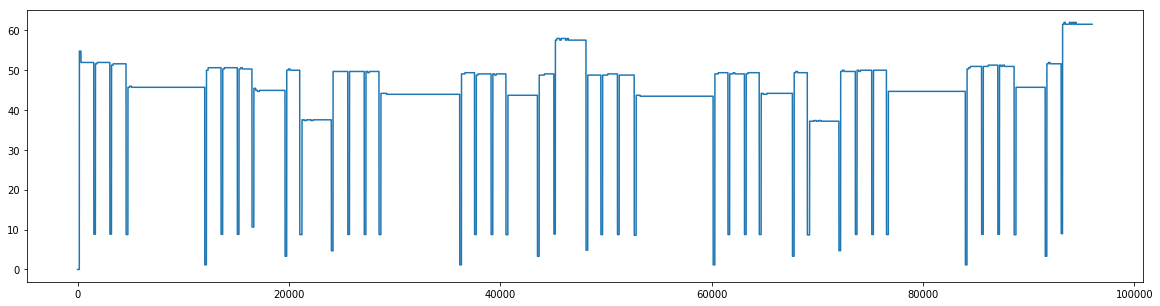

In [75]:
plot(pitches)
plt.savefig(filepre("seqpitchesRecovered.pdf"))

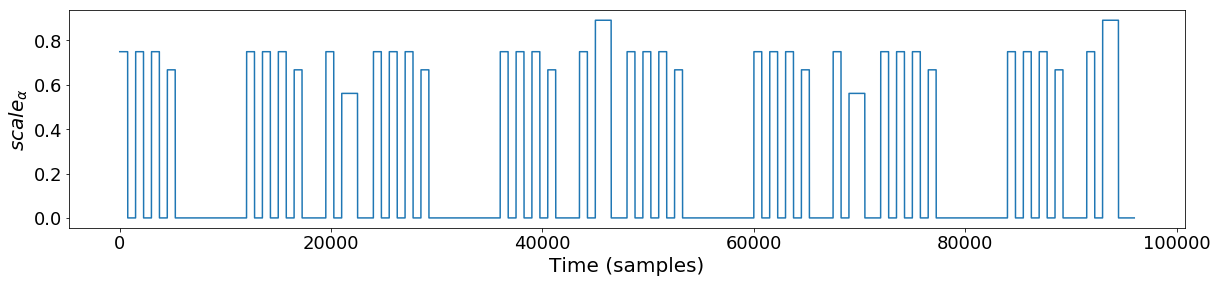

In [86]:
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel(r'$scale_{\alpha}$', fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plot(lrCtl)
plt.savefig(filepre("lrctl.pdf"), bbox_inches='tight')

/home/chrisk/env3/lib/python3.5/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


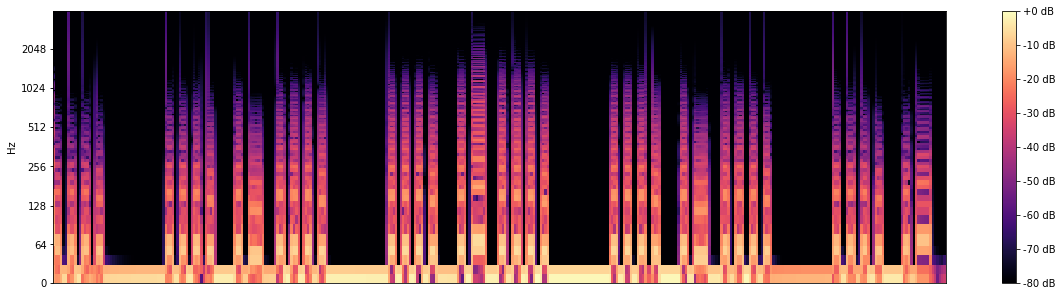

In [76]:
figsize(20,5)
import librosa.display
CQT = librosa.amplitude_to_db(librosa.stft(audio3, n_fft=512, hop_length=256), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=8000)
plt.colorbar(format='%+2.0f dB')
#ax.set_title('Reconstruction', fontsize=22)
plt.savefig(filepre("sequence.pdf"))